In [ ]:
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gymnasium.utils.env_checker import check_env
import gymnasium as gym
from gridworld_env.GridWorld import GridWorldEnv

torch.cuda.empty_cache()

SEED = 50

random.seed(SEED)
torch.manual_seed(SEED)

# --- Configuración de Gráficos (si se ejecuta en un notebook) ---
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# --- Configuración del Dispositivo (GPU o CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Clase ReplayBuffer (Memoria de Repetición) ---
# (La misma que discutimos antes)
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer:
    """Memoria de tamaño fijo para almacenar tuplas de experiencia."""

    def __init__(self, capacity):
        """
        Inicializador.

        Args:
            capacity (int): Tamaño máximo del buffer.
        """
        # deque es una lista optimizada para añadir y quitar elementos de los extremos
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Guarda una nueva experiencia en la memoria."""
        self.memory.append(Experience(*args))

    def sample(self, batch_size):
        """
        Obtiene una muestra aleatoria de 'batch_size' experiencias.

        Args:
            batch_size (int): El tamaño del minibatch a muestrear.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Devuelve el tamaño actual de la memoria."""
        return len(self.memory)
    
class DQN(nn.Module):
    """
    Una red neuronal simple para aproximar la función Q.
    """
    def __init__(self, n_observations, n_actions):
        """
        Inicializador.

        Args:
            n_observations (int): La dimensionalidad del espacio de estados.
                                (Ej: 4 para CartPole).
            n_actions (int): El número de acciones discretas posibles.
                            (Ej: 2 para CartPole, izquierda o derecha).
        """
        super(DQN, self).__init__()
        # Definimos las capas de la red
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, n_actions)

    def forward(self, x):
        """
        El paso hacia adelante (forward pass).
        Define cómo la entrada (estado) se transforma en la salida (valores Q).
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        # La salida no lleva función de activación porque queremos los valores Q brutos.
        return self.layer3(x)
    
# --- Hiperparámetros ---
BATCH_SIZE = 128       # Tamaño del minibatch muestreado del buffer
GAMMA = 0.99          # Factor de descuento
EPS_START = 1         # Valor inicial de épsilon (exploración)
EPS_END = 0.05        # Valor final de épsilon (más bajo para mejor explotación)
EPS_DECAY = 80000
TAU = 0.005           # Tasa de actualización de la red objetivo (soft update)
LR = 5e-4             # Tasa de aprendizaje para el optimizador AdamW
steps_done = 0
WARMUP_STEPS = 2000   # Pasos de exploración pura antes de optimizar
MEMORY_BUFFER = 10000 # Buffer grande para mayor diversidad de experiencias

# --- Inicialización de Entorno ---
size = 5
goal = (1, 0)  # Goal: columna 1, fila inferior (y=0 está abajo en GridWorld)


env = gym.make("entropia/GridWorld-v0", size=size, reward_scale=100, step_penalty=1, render_mode="ansi",
                       obstacles=[(3, 4), (0, 3), (1, 3), (4, 2), (1, 1), (3, 1),(1,0)],
                       invalid_move_penalty=2,   # penalización extra por chocar con obstáculo/borde
                       block_on_obstacle=True)
check_env(env.unwrapped)

n_actions = env.action_space.n
state_obs, info = env.reset(options={"agent_start": (2, 4), "goal": goal})  # Agente en centro superior
n_observations = len(GridWorldEnv.transform_obs(state_obs, size=env.unwrapped.size))

# Red principal y red objetivo
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # Copiamos los pesos

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(MEMORY_BUFFER)

e_counter = 0
episode_durations = []


# --- Funciones Auxiliares ---
def select_action(state):
    global steps_done
    # warmup por pasos
    if steps_done < WARMUP_STEPS:
        steps_done += 1
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    eps = EPS_END + (EPS_START - EPS_END) * math.exp(-(steps_done - WARMUP_STEPS) / EPS_DECAY)
    steps_done += 1

    if random.random() > eps:
        with torch.no_grad():
            return policy_net(state).argmax(1).view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def plot_durations(show_result=False):
    """
    Función para graficar el progreso del entrenamiento.
    """
    global steps_done
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        # add steps_done and epsilon
        epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-(steps_done - WARMUP_STEPS) / EPS_DECAY)
        plt.title(f'Training...{f" Epsilon: {epsilon:.2f} Steps: {steps_done}"}')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Tomamos el promedio de los últimos 10 episodios para ver la tendencia
    if len(durations_t) >= 10:
        means = durations_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # Pausa para que el gráfico se actualice
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


# --- Bucle de Entrenamiento Principal ---
def optimize_model():
    """
    Realiza un paso de optimización en la red principal.
    """

    if len(memory) < BATCH_SIZE:
        return # No hacemos nada si no hay suficientes experiencias

    transitions = memory.sample(BATCH_SIZE)
    # Transpone el batch. Convierte un batch de tuplas Experience
    # a una tupla de batches. Ej: (s1,s2,..), (a1,a2,..), etc.
    batch = Experience(*zip(*transitions))

    # Creamos máscaras para estados que no son finales
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # 1. Calcular Q(s, a) para las acciones que se tomaron
    # La red predice Q(s) para todas las acciones, y luego usamos .gather()
    # para seleccionar solo los valores de las acciones que realmente se tomaron.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 2. Calcular el valor del siguiente estado para DDQN
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    if non_final_mask.any():  # Only compute if there are non-final states
        with torch.no_grad():
            # 2.1. Seleccionar la mejor acción usando la policy_net
            best_actions = policy_net(non_final_next_states).argmax(1, keepdim=True)
            # 2.2. Evaluar el valor de esa acción usando la target_net
            q_values_target = target_net(non_final_next_states)
            next_state_values[non_final_mask] = q_values_target.gather(1, best_actions).squeeze(1)

    # 3. Calcular el TD Target: r + γ * V(s')
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 4. Calcular la pérdida (Loss)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 5. Optimizar el modelo
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping para evitar explosiones de gradientes
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
    optimizer.step()

def flush_replay_keep_frac(keep_frac=0.1):
    global memory
    keep_n = max(0, int(len(memory) * keep_frac))
    kept = memory.sample(keep_n) if keep_n > 0 else []
    memory = ReplayBuffer(MEMORY_BUFFER)
    for exp in kept:
        memory.push(exp.state, exp.action, exp.next_state, exp.reward)

def reset_optimizer():
    global optimizer
    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

Using device: cuda
. . . # A
# # . . .
. . . . #
. # . T .
. # . . .
 0 1 2 3 4


Complete


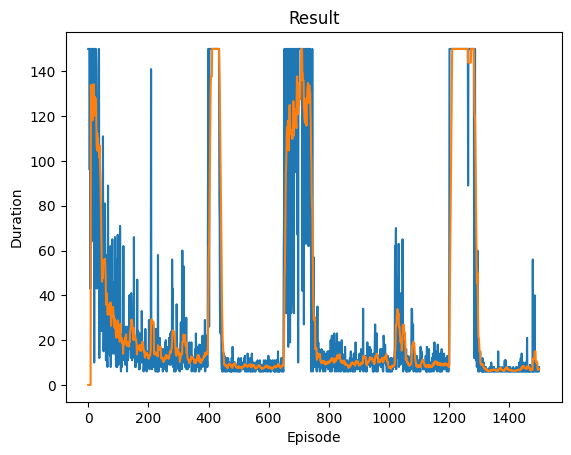

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
# --- Ejecución del Entrenamiento ---
num_episodes = 1500
switch_1 = 650
switch_2 = 1201

for i_episode in range(num_episodes):

    just_switched = False
    if i_episode == 0:
        current_goal = (0, 0)  # Goal en columna 1, fila inferior
    elif i_episode == switch_1:
        current_goal = (4,0)
        just_switched = True
    elif i_episode == switch_2:
        current_goal = (0,0)
    #    just_switched = True

    if just_switched:
        steps_done = 0
        #flush_replay_keep_frac(0.1)
        #reset_optimizer()

    state, info = env.reset(options={"agent_start": (2, 4), "goal": current_goal})  # Agente en centro superior

    state = GridWorldEnv.transform_obs(state, size=env.unwrapped.size)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            # Si truncated (no terminated), aún guardamos next_state para no perder
            # la estimación de valor futuro (bootstrap correcto)
            observation = GridWorldEnv.transform_obs(observation, size=env.unwrapped.size)
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        # Guardar la transición en la memoria
        memory.push(state, action, next_state, reward)

        # Mover al siguiente estado
        state = next_state

        # Realizar un paso de optimización en la red principal
        optimize_model()
 
        # "Soft update" de los pesos de la red objetivo
        # θ_target = τ*θ_policy + (1 - τ)*θ_target
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        #print(env.render(),reward)
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)

plt.ioff()
plt.show()

In [3]:
# plot the agent in the environment
state, info = env.reset(options={"agent_start": (2, 2), "goal": (4,0)})  # Agente en centro superior
print(env.render())
done = False
while not done:
    state_transformed = GridWorldEnv.transform_obs(state, size=env.unwrapped.size)
    state_tensor = torch.tensor(state_transformed, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        action = policy_net(state_tensor).argmax(1).item()
    state, reward, terminated, truncated, _ = env.step(action)
    print(env.render())
    done = terminated or truncated

. . . # .
# # . . .
. . A . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # .
# # . . .
. A . . #
. # . # .
. # . . T
 0 1 2 3 4

. . . # 

In [4]:
# see the q_values for the initial state
state, info = env.reset(options={"agent_start": (2, 4), "goal": current_goal})
# Agente en centro superior

In [5]:
print(env.render())

. . A # .
# # . . .
. . . . #
. # . # .
T # . . .
 0 1 2 3 4

